# Implementation Details

The following is an implementation of a decision tree and random forest for classification on the Titanic and Spam datasets. The decision tree calculates a split that maximizes information gain, and builds a tree structure maintaining class probabilities. Traversal stops when a class reaches a probability of 1.0, or we reach a specified maximum depth. The random forest implements the bagging ensemble method, training individual trees on random subsets of the data, then outputting the mode of all predictions.

# Decision Trees

In [1]:
import numpy as np
import pandas as pd
from numpy import genfromtxt
import scipy.io
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts
%matplotlib inline

class Node:
    """
    A single node in the decision tree:
    
    left: pointer to left subtree
    right: pointer to right subtree
    split_rule: A pair containing a feature and threshold to split on (f, t).
    depth: The current depth of the node in the tree
    probs: Probability of each class label at this node
    """
    def __init__(self, left, right, rule, depth, probs = None):
        self.split_rule = rule
        self.left = left
        self.right = right
        self.depth = depth
        self.probs = probs
    
class DecisionTree:
    
    def __init__(self, features, classes):
        self.classes = classes
        self.class_indices = np.arange(len(classes))
        self.features = features
    def calc_probs(self, y):
        return np.array([np.mean([y == label * np.ones(len(y))]) for label in self.class_indices])
        
    def entropy(self, y):
        """
        Calculates the entropy given all the labels
        """
        return stats.entropy(self.calc_probs(y))

    def information_gain(self, X, y, idx, thresh):
        """
        Calculates information gain given a vector of features and a split threshold
        """
        left, right = self.split(X, y, idx, thresh)
        left_H = self.entropy(y[left]) if list(left) else 0
        right_H = self.entropy(y[right]) if list(right) else 0
        H_after = (len(left) * left_H + len(right) * right_H) / len(y)
        return self.entropy(y) - H_after

    def split(self, X, y, idx, thresh):
        """
        Returns a split of the dataset given an index of the feature and
        a threshold for it
        
        """
        left, right = [], []
        f = self.features[idx]
        for i in range(len(X)):
            point = X[i]
            comparison = lambda x,y : (x == y if f in ["pclass", "sex", "embarked"] else x < y)
            if comparison(point[idx], thresh):
                left.append(i)
            else:
                right.append(i)
        return np.array(left), np.array(right)
        
    def segmenter(self, X, y):
        """
        Compute entropy gain for all single-dimension splits,
        return the feature and the threshold for the split that
        has maximum gain
        """
        best_gain = -float('inf')
        best_pair = None
        for i in range(len(self.features)):
            thresholds = list(set(X[:,i]))
            for threshold in thresholds:
                curr_gain = self.information_gain(X, y, i, threshold)
                if curr_gain > best_gain:
                    best_pair = (i, threshold)
                    best_gain = curr_gain
        return best_pair
             
    def fit(self, X, y, max_depth):
        """
        Fit the model to a training set.
        """
        self.root = self.grow_tree(X, y, 0, max_depth)
        
    def grow_tree(self, X, y, curr_depth, max_depth):
        probs = self.calc_probs(y)
        feature, threshold = self.segmenter(X, y)
        left, right = self.split(X, y, feature, threshold)
        X_left = None if not list(left) else X[left]
        y_left = None if not list(left) else y[left]
        X_right = None if not list(right) else X[right]
        y_right = None if not list(right) else y[right]
        if 1.0 in probs or curr_depth == max_depth:
            return Node(None, None, None, curr_depth, probs)
        if X_left is not None:
            left_node = self.grow_tree(X_left, y_left, curr_depth + 1, max_depth)
        else:
            left_node = Node(None, None, None, curr_depth + 1, probs)
        if X_right is not None:
            right_node = self.grow_tree(X_right, y_right, curr_depth + 1, max_depth)
        else:
            right_node = Node(None, None, None, curr_depth + 1, probs)
        return Node(left_node, right_node, (feature, threshold), curr_depth)
   
    def predict(self, X):
        """
        Predict the labels for input data 
        """
        y = []
        for point in X:
            node = self.root
            while node is not None and node.probs is None:
                feature, threshold = node.split_rule
                comparison = lambda x,y : (x == y if self.features[feature] in ["pclass", "sex", "embarked"] else x < y)
                node = node.left if comparison(point[feature], threshold) else node.right
            y.append(np.argmax(node.probs))
        return np.array(y)
                    
    """
    Visualization method for the tree
    """    
    def generateString(self, node):
        if not node:
            return ""
        if node.probs is not None:
            output = "("
            for i in range(len(node.probs)):
                output += f"{self.classes[i]} : {node.probs[i]}, "
            output = output[:-2] + ")\n"
            return "\t" * node.depth + output
        fidx, thresh = node.split_rule
        return "\t" * node.depth + f"{self.features[fidx]}, {thresh}\n" \
             + "\t" * node.left.depth \
             + self.generateString(node.left) \
             + "\t" * node.right.depth \
             + self.generateString(node.right)
    
    def __repr__(self):
        
        return self.generateString(self.root)
    
    


# Random Forests

In [2]:
class RandomForest:
    
    def __init__(self, features, classes, num_trees):
        """
        Initialization of a random forest
        """
        self.trees = np.array([DecisionTree(features, classes) for _ in range(num_trees)])
    def fit(self, X, y, max_depth):
        """
        Fit the model to a training set
        """
        for tree in self.trees:
            X_t, y_t = [], []
            for _ in range(len(y)):
                idx = np.random.randint(len(y))
                X_t.append(X[idx])
                y_t.append(y[idx])
            
            tree.fit(np.array(X_t), np.array(y_t), max_depth)
    
    def predict(self, X):
        """
        Predict the labels for input data 
        """
        predictions = np.array([tree.predict(X) for tree in self.trees])
        final_predictions = np.array([stats.mode(predictions[:, i])[0][0] for i in range(len(predictions[0]))])
        return final_predictions

# Perfomance Evaluation

In this section, we will preprocess the data to encode categorical values and fill in missing values. Then, we will train our models and measure their performance.

In [3]:
# Check if s is a numerical value
def is_numeric(s):
    try:
        float(s)
        return True
    except (ValueError, TypeError):
        return False
# Preprocess the data by converting from strings to floats, and encoding categorical data with the LabelEncoder      
def process_data(features, dataset):
    for i in range(len(features)):
            column = dataset[:,i]
            for j in range(len(column)):
                if column[j] == '':
                    values = np.array([x for x in column if x != ''])
                    if all(list(map(is_numeric, values))):
                        values = values.astype(np.float64)
                        column[j] = np.mean(values)
            dataset[:,i] = column
            # Label encoding for categorical features
            le = LabelEncoder()
            if not is_numeric(dataset[0,i]):
                le.fit(dataset[:,i])
                dataset[:,i] = le.transform(dataset[:,i])
    
    return dataset.astype(np.float64)

"""
Read in the datasets from given files and run preprocessing.
"""
def generate_data(dataset):
    # The titanic dataset requires preprocessing to convert categorical data and fill in missing values
    if dataset == "titanic":
    # Load titanic data       
        data = genfromtxt('titanic_training.csv', delimiter=',', dtype=None)
        test_data = genfromtxt('titanic_testing_data.csv', delimiter=',', dtype=None)
        y = data[1:, 0]
        class_names = ["Died", "Survived"]
        features = data[0].astype(np.str)
        data = process_data(features, data[1:].astype(np.str))
        test_features = test_data[0].astype(np.str)
        test_data = process_data(test_features, test_data[1:].astype(np.str))
        y = y.astype(np.str)
        empty_indices = [i for i in range(len(y)) if y[i] == '']
        # Remove the indices with empty data
        for i in empty_indices:
            data = np.delete(data,i,0)
            y = np.delete(y,i)
        y = y.astype(np.int)
    # The spam dataset does not require the above preprocessing: simply load the data    
    elif dataset == "spam":
        features = [
        "pain", "private", "bank", "money", "drug", "spam", "prescription",
        "creative", "height", "featured", "differ", "width", "other",
        "energy", "business", "message", "volumes", "revision", "path",
        "meter", "memo", "planning", "pleased", "record", "out",
        "semicolon", "dollar", "sharp", "exclamation", "parenthesis",
        "square_bracket", "ampersand"
        ]
        assert len(features) == 32

    # Load spam data
        data = scipy.io.loadmat('spam_data.mat')
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        test_data = data['test_data']
        class_names = ["Ham", "Spam"]
        data = X
    return data, y, test_data, features, class_names
         
    

titanic_X, titanic_y, titanic_test, titanic_features, titanic_classes = generate_data("titanic")
spam_X, spam_y, spam_test, spam_features, spam_classes = generate_data("spam")
titanic_X = np.delete(titanic_X,0,1)
titanic_features = titanic_features[1:]

/Users/nprasad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
/Users/nprasad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


Here we measure the performance of both models through training and validation accuracies.

In [4]:
# Train and validate both models, outputting training and validation accuracies
X_train_t, X_val_t, y_train_t, y_val_t = tts(titanic_X, titanic_y, test_size=0.8, random_state=42)
X_train_s, X_val_s, y_train_s, y_val_s = tts(spam_X, spam_y, test_size=0.8, random_state=42)
titanic_tree = DecisionTree(titanic_features, titanic_classes)
titanic_forest = RandomForest(titanic_features, titanic_classes, 5)
spam_tree = DecisionTree(spam_features, spam_classes)
spam_forest = RandomForest(spam_features, spam_classes, 5)
titanic_tree.fit(X_train_t, y_train_t, 10)
titanic_forest.fit(X_train_t, y_train_t, 10)
spam_tree.fit(X_train_s, y_train_s, 10)
spam_forest.fit(X_train_s, y_train_t, 10)
titanic_tree_pred_tr = titanic_tree.predict(X_train_t)
titanic_tree_pred_va = titanic_tree.predict(X_val_t)
spam_tree_pred_tr = spam_tree.predict(X_train_s)
spam_tree_pred_va = spam_tree.predict(X_val_s)
titanic_forest_pred_tr = titanic_forest.predict(X_train_t)
titanic_forest_pred_va = titanic_forest.predict(X_val_t)
spam_tree_forest_tr = spam_forest.predict(X_train_s)
spam_tree_forest_va = spam_forest.predict(X_val_s)


In [5]:
def calc_acc(pred, actual):
    
    return np.mean(pred == actual)

training_acc_titanic_tree = calc_acc(titanic_tree_pred_tr, y_train_t)
validation_acc_titanic_tree = calc_acc(titanic_tree_pred_va, y_val_t)
training_acc_titanic_forest = calc_acc(titanic_forest_pred_tr, y_train_t)
validation_acc_titanic_forest = calc_acc(titanic_forest_pred_va, y_val_t)
training_acc_spam_tree = calc_acc(spam_tree_pred_tr, y_train_s)
validation_acc_spam_tree = calc_acc(spam_tree_pred_va, y_val_s)
training_acc_spam_forest = calc_acc(spam_tree_forest_tr, y_train_s)
validation_acc_spam_forest = calc_acc(spam_tree_forest_va, y_val_s)
print(f"Training accuracy for Titanic with Decision Tree: {training_acc_titanic_tree}")
print(f"Validation accuracy for Titanic with Decision Tree: {validation_acc_titanic_tree}")
print(f"Training accuracy for Titanic with Random Forest: {training_acc_titanic_forest}")
print(f"Validation accuracy for Titanic with Random Forest: {validation_acc_titanic_forest}")
print(f"Training accuracy for Spam with Decision Tree: {training_acc_spam_tree}")
print(f"Validation accuracy for Spam with Decision Tree: {validation_acc_spam_tree}")
print(f"Training accuracy for Spam with Random Forest: {training_acc_spam_forest}")
print(f"Validation accuracy for Spam with Random Forest: {validation_acc_spam_forest}")

Training accuracy for Titanic with Decision Tree: 0.9547738693467337
Validation accuracy for Titanic with Decision Tree: 0.74
Training accuracy for Titanic with Random Forest: 0.9698492462311558
Validation accuracy for Titanic with Random Forest: 0.73375
Training accuracy for Spam with Decision Tree: 0.8558994197292069
Validation accuracy for Spam with Decision Tree: 0.7982116964717255
Training accuracy for Spam with Random Forest: 0.6392649903288201
Validation accuracy for Spam with Random Forest: 0.6295311744804253


Here we plot the validation error as a function of tree depth for both the decision tree and random forest.

Text(0.5, 1.0, 'Validation Error on Spam Dataset')

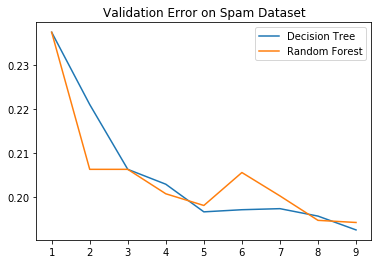

In [6]:
def error(y_pred, y):
    return 1 - calc_acc(y_pred, y)

X_train_s, X_val_s, y_train_s, y_val_s = tts(spam_X, spam_y, test_size=0.8, random_state=27)
errors_tree = []
errors_forest = []
tree = DecisionTree(spam_features, spam_classes)
forest = RandomForest(spam_features, spam_classes, 4)

for i in range(1,10):
    tree.fit(X_train_s, y_train_s,i)
    forest.fit(X_train_s, y_train_s, i)
    errors_tree.append(error(tree.predict(X_val_s), y_val_s))
    errors_forest.append(error(forest.predict(X_val_s), y_val_s))
    
plt.plot(list(range(1,10)), errors_tree, label="Decision Tree")
plt.plot(list(range(1,10)), errors_forest, label="Random Forest")
plt.legend()
plt.title("Validation Error on Spam Dataset")

In [7]:
# Sample visualization of Decision Tree structure
titanic = DecisionTree(titanic_features, titanic_classes)
titanic.fit(titanic_X, titanic_y, 3)
print(titanic)

sex, 1.0
		pclass, 3.0
				fare, 23.45
						(Died : 0.42142857142857143, Survived : 0.5785714285714286)
						(Died : 0.9, Survived : 0.1)
				embarked, 3.0
						(Died : 0.08, Survived : 0.92)
						(Died : 0.0, Survived : 1.0)
		cabin, 6.0
				age, 4.0
						(Died : 0.35714285714285715, Survived : 0.6428571428571429)
						(Died : 0.8651252408477842, Survived : 0.1348747591522158)
				age, 18.0
						(Died : 0.0, Survived : 1.0)
						(Died : 0.6605504587155964, Survived : 0.3394495412844037)



Here we will generate our predictions on a test set, and write them to a CSV file.

In [8]:
# Write our results to CSV file
def results_to_csv(y_test, name):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1. 
    csv_name = name + '.csv'
    df.to_csv(csv_name, index_label='Id')

In [9]:
# Fit decision tree and random forest to both datasets, then generate predictions
tree_t = DecisionTree(titanic_features, titanic_classes)
tree_s = DecisionTree(spam_features, spam_classes)
forest_t = RandomForest(titanic_features, titanic_classes, 10)
forest_s = RandomForest(spam_features, spam_classes, 10)
tree_t.fit(titanic_X,titanic_y, 10)
tree_s.fit(spam_X,spam_y, 3)
forest_t.fit(titanic_X, titanic_y, 3)
forest_s.fit(spam_X, spam_y,3)
titanic_test_tree = tree_t.predict(titanic_test)
spam_test_tree = tree_s.predict(spam_test)
titanic_test_forest = forest_t.predict(titanic_test)
spam_test_forest = forest_s.predict(spam_test)

In [10]:
# Write a CSV file for each set of predictions
results_to_csv(titanic_test_tree, "titanic_tree")
results_to_csv(spam_test_tree, "spam_tree")
results_to_csv(spam_test_forest, "spam_forest")
results_to_csv(titanic_test_forest, "titanic_forest")